# Première partie : Scraping de tous les films dans Allociné

Importation des librairies

In [2]:
from bs4 import BeautifulSoup as soup
from requests import get
from time import sleep
from random import randint
import pandas as pd 

Fonction permettant de scraper le site Allocine

In [ ]:
def scrap(start_page, end_page): 
    
    # Colonne du dataframe
    c = ['titre','auteur','description','date_sortie','note_presse','note_spectateur','genre_1','genre_2','genre_3','duree']
    df = pd.DataFrame(columns=c)
    
    # Boucle pour Récupérer les liens des différentes pages du site à scraper
    # Et pour parcourir chaque page
    for p in range(start_page, end_page):
        if p == 1:
            url_films = 'http://www.allocine.fr/films/decennie-2010/'
        else:
            url_films = 'http://www.allocine.fr/films/decennie-2010/?page={}'.format(str(p))
        #print(url)
        
        response = get(url_films)
        sleep(randint(1,2))
        html_soup = soup(response.text, 'html.parser')
        
        # Boucle pour parcourir chaque film
        for films in html_soup.find_all('li', 'mdl'):
                       
            for link in films.findAll('a', 'meta-title-link'):
                links = 'http://www.allocine.fr' + link.get('href')
                #print (links)
                
                response_film = get(links)
                html_soup_film = soup(response_film.text, 'html.parser')
                
                for info in html_soup_film.find_all('div', 'sub-body'):
                
                    titre = info.find('div', 'titlebar-title titlebar-title-lg')
                    try:
                        titre = titre.text
                        titre = titre.replace(',', ';')
                        #print(titre)
                    except AttributeError:
                        titre = ''
                        #print(titre)
                    
                    auteur = info.find('a', 'blue-link')
                    try:
                        auteur = auteur.text
                        auteur = auteur.replace(',', ';')
                        #print(auteur)
                    except AttributeError:
                        auteur = ''
                        #print(auteur)
                        
                    description = info.find('div', 'content-txt')
                    try:
                        description = description.text.strip()
                        description = description.replace(',', ';')
                        #print(description)
                    except AttributeError:
                        description = ''
                        #print(description)
                    
                    date_sortie = info.select('.date')
                    if date_sortie:
                        for i in date_sortie:
                            try:
                                date_sortie = i.text
                                date_sortie = date_sortie.strip()
                                #print(date_sortie)
                            except AttributeError:
                                date_sortie = ''
                                #print(date_sortie)
                    else:
                        date_sortie = ''
                        #print(date_sortie)
               
                    notes = info.find('div', 'rating-holder rating-holder-3')
                    #print(notes)
                    try:
                        if notes:
                            notes = notes.select('.rating-item')
                            for i in notes:
                                if (i.span):
                                    # Extraire la notes de la presse pour chaque film
                                    if i.span.text.strip() == 'Presse':
                                        note_presse = i.div.div.span.text.replace(',', '.')
                                        note_presse = note_presse.replace('--', '')
                                        #print(note_presse)           
                                    # Extraire la notes de la presse pour chaque film
                                    elif i.span.text.strip() == 'Spectateurs':
                                        note_spectateur = i.div.div.span.text.replace(',', '.')
                                        note_spectateur = note_spectateur.replace('--', '')
                                        #print(note_spectateur)
                    except AttributeError:
                        note_presse = ''
                        #print(note_presse)
                        note_spectateur = ''
                        #print(note_spectateur)
                   
                    try:
                        genre = info.find_all('div', class_= 'meta-body-item')[3].text.replace('Genres','')
                        genre = genre.replace('Genre', '').split(',')
                        
                        if len(genre) == 3:
                            genre_3 = genre[2].strip()
                            genre_3 = genre_3.replace(',', ';')
                            #print(genre_3)
                        elif len(genre) == 2:
                            genre_2 = genre[1].strip()
                            genre_2 = genre_2.replace(',', ';')
                            #print(genre_2)
                        elif len(genre) == 1:
                            genre_1 = genre[0].strip()
                            genre_1 = genre_1.replace(',', ';')
                            #print(genre_1)
                        else:
                            genre_1 = ''
                            genre_2 = ''
                            genre_3 = ''
                    except:
                        genre_1 = ''
                        genre_2 = ''
                        genre_3 = ''
                                              
                    try:
                        duree = info.find_all('div', class_= 'meta-body-item')[0].text
                        duree = ' '.join(duree.split())
                        duree = duree.split('(')
                        duree = duree[1].replace(')','')
                        #print(duree)
                    except:
                        duree = ''
                        #print(duree)
                        
                    # Ajout des données dans le dataframe 
                    try:
                        df_films = pd.DataFrame({'titre': [titre],
                                                 'auteur': [auteur],
                                                 'description': [description],
                                                 'date_sortie': [date_sortie],
                                                 'note_presse': [note_presse],
                                                 'note_spectateur': [note_spectateur],
                                                 'genre_1': [genre_1],
                                                 'genre_2': [genre_2],
                                                 'genre_3': [genre_3],
                                                 'duree': [duree]})
                        
                        df = pd.concat([df, df_films])
                    except UnboundLocalError:
                        pass
                    
    # Exporter le dataframe en csv                    
    df.to_csv(r'C:\Users\lahat\Documents\M2 IMSD\Python_IMSD\scraping_IMSD\films.csv', index=False)
    #return df

# Les 1000 premières pages du site
scrap(1, 700)   

# Deuxième partie : Analyse

Importation des librairies à utiliser pour l'analyse

In [3]:
import pandas as pd 
import numpy as np
from datetime import datetime
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import re
import unicodedata
import nltk

from wordcloud import WordCloud
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('punkt')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

C:\Users\lahat\Anaconda3\lib\site-packages\matplotlib\__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
C:\Users\lahat\Anaconda3\lib\site-packages\matplotlib\__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
C:\Users\lahat\Anaconda3\lib\site-packages\seaborn\apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lahat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\la

Importation du fichier csv

In [5]:
films = pd.read_csv(r'C:\Users\lahat\Documents\M2IMSD\Python_IMSD\scraping_IMSD\films.csv', encoding='utf8', delimiter=',')

In [6]:
films.shape

(1479, 10)

# ANALYSE DESCRIPTIVE

In [7]:
films.head()

,titre,auteur,description,date_sortie,note_presse,note_spectateur,genre_1,genre_2,genre_3,duree
0,La Reine des neiges 2,Jennifer Lee,Pourquoi Elsa est-elle née avec des pouvoirs m...,20 novembre 2019,3.3,3.9,Animation,Drame,Drame,1h 44min
1,La Famille Addams,Conrad Vernon,La famille Addams; qui vivait jusque-là retran...,4 décembre 2019,2.9,2.8,Animation,Famille,Drame,1h 27min
2,Star Wars: L'Ascension de Skywalker,J.J. Abrams,La conclusion de la saga Skywalker. De nouvell...,18 décembre 2019,2.9,2.8,Animation,Aventure,Drame,NaN
3,J'accuse,Roman Polanski,Pendant les 12 années qu’elle dura; l’Affaire ...,13 novembre 2019,4.0,3.8,Animation,Aventure,Thriller,2h 12min
4,Une vie cachée,Terrence Malick,Inspiré de faits réels.Franz Jägerstätter; pay...,11 décembre 2019,4.0,3.8,Animation,Biopic,Thriller,2h 53min


In [8]:
# Types de variables 
films.dtypes

titre               object
auteur              object
description         object
date_sortie         object
note_presse        float64
note_spectateur    float64
genre_1             object
genre_2             object
genre_3             object
duree               object
dtype: object

In [9]:
# Supression des données manquantes
films = films.dropna()
print(films.isna().sum())

titre              0
auteur             0
description        0
date_sortie        0
note_presse        0
note_spectateur    0
genre_1            0
genre_2            0
genre_3            0
duree              0
dtype: int64


In [10]:
# Extraction de l'année dans une colonne
films['annee'] = films['date_sortie'].str[-4:]
films['annee'].value_counts()

2019    451
2018    205
2017    121
2016    115
2015     74
2014     61
2013     54
2011     52
2012     44
2020     38
2010     27
2009      1
Name: annee, dtype: int64

In [11]:
# Garder les films de 2010  à 2019
films = films[~films['annee'].str.contains('2002|2009|2020|2021')]

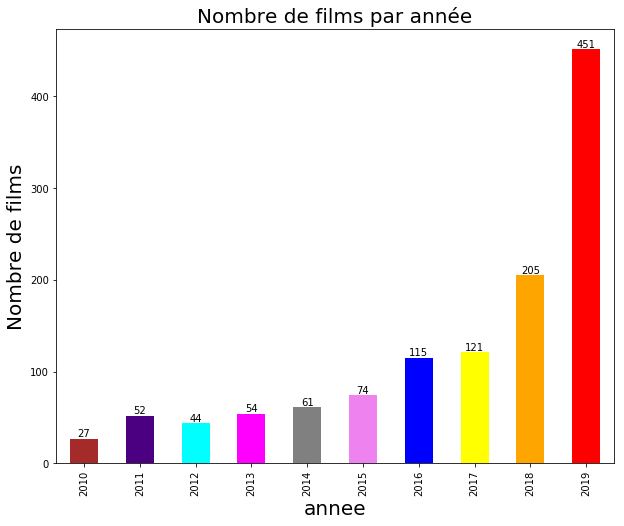

In [12]:
# Calculer le nombre de films par année
films_annee = films.groupby('annee').agg({'titre': 'count'}).reset_index()
# Graphique du nombe de films par année 
# Définir pour chaque anneee sa propore couleur
colors = []
 
for i in films_annee['annee']:
    if i == '2019':
        colors.append('red')
    elif i == '2018':
        colors.append('orange')
    elif i == '2017':
        colors.append('yellow')
    elif i == '2016':
        colors.append('blue')
    elif i == '2015':
        colors.append('violet') 
    elif i == '2014':
        colors.append('grey')
    elif i == '2013': 
        colors.append('fuchsia')
    elif i == '2012':
        colors.append('aqua')
    elif i == '2011':
        colors.append('indigo')
    elif i == '2010':
        colors.append('brown')
    else:
        colors.append('beige')
        
films_annee.plot.bar(x='annee', y='titre', color = colors, figsize=(10, 8), legend=False, fontsize=10)
plt.title('Nombre de films par année', fontsize=20)
plt.xlabel('annee', fontsize=20)
plt.ylabel('Nombre de films', fontsize=20)
# Afficher les étiquettes sur le graphique
for i, val in enumerate(films_annee["titre"]):
        plt.text(i, val, str(val),ha='center', va='bottom')

Distribution des notes

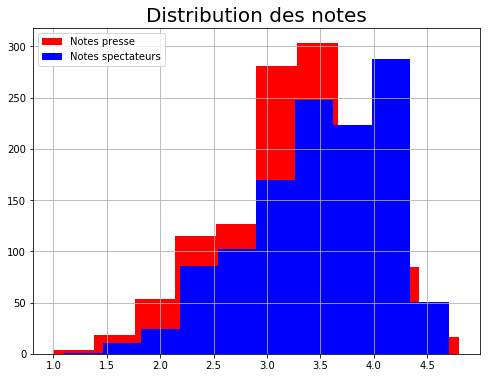

In [13]:
fig = plt.figure(figsize=(8, 6))
films["note_presse"].hist(color="red", label='Notes presse')
films["note_spectateur"].hist(color="blue", label='Notes spectateurs')
plt.title('Distribution des notes', fontsize=20)
plt.legend()

In [14]:
stat_note = films[["note_presse", "note_spectateur"]].describe()
stat_note

,note_presse,note_spectateur
count,1204.000000,1204.000000
mean,3.209967,3.484801
std,0.633152,0.640054
min,1.000000,1.100000
25%,2.800000,3.000000
50%,3.300000,3.600000
75%,3.700000,4.000000
max,4.800000,4.700000


Réduire notre dataframe pour faire une étude en fonction de la durée des films

In [15]:
col_to_keep = ["note_presse","note_spectateur", "duree", "titre", "genre_1","genre_2","genre_3"]
films_duree = films[col_to_keep]
# Remplacer les caractères dans la colonne durée
films_duree["duree"] = films_duree["duree"].str.replace('h', ':')
films_duree["duree"] = films_duree["duree"].str.replace('min', '')
# Convertir la durée au format date
films_duree['heure'] = pd.to_datetime(films_duree['duree'].str.strip(), format='%H: %M')
# Extraire l'heure dans une colonne
films_duree['heure'] = films_duree['heure'].apply(lambda x: x.strftime('%H'))
films_duree.head()

C:\Users\lahat\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\lahat\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\lahat\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.

,note_presse,note_spectateur,duree,titre,genre_1,genre_2,genre_3,heure
0,3.3,3.9,1: 44,La Reine des neiges 2,Animation,Drame,Drame,01
1,2.9,2.8,1: 27,La Famille Addams,Animation,Famille,Drame,01
3,4.0,3.8,2: 12,J'accuse,Animation,Aventure,Thriller,02
4,4.0,3.8,2: 53,Une vie cachée,Animation,Biopic,Thriller,02
5,3.8,4.4,2: 33,Le Mans 66,Animation,Drame,Thriller,02


Définire les classes d'heure et représenter la répartition

Text(0.5, 1.0, 'Répartition des films par note presse')

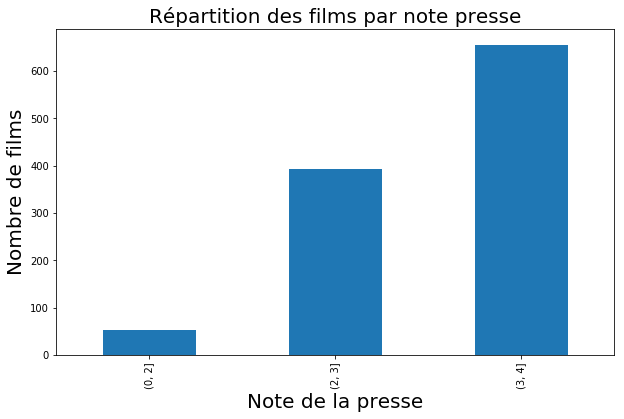

In [16]:
bins = [0, 2, 3, 4]
# Faire un regroupement en fontion des classes
classe_note = films_duree.groupby(pd.cut(films_duree['note_presse'], bins=bins)).note_presse.count()
classe_note.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Note de la presse', fontsize=20)
plt.ylabel('Nombre de films', fontsize=20)
plt.title('Répartition des films par note presse', fontsize=20)

C:\Users\lahat\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Text(0.5, 1.0, 'Identifier les films les mieux notés selon le genre 2')

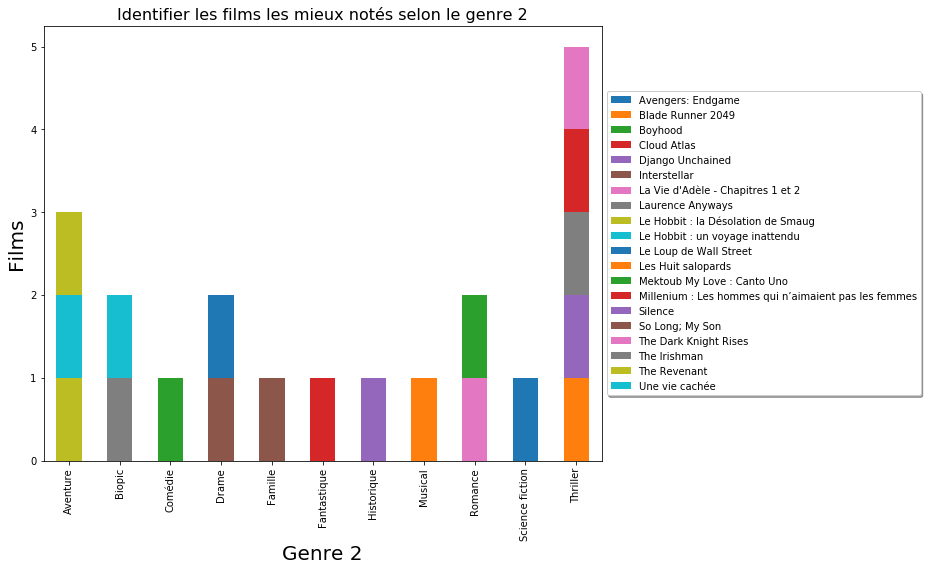

In [17]:
# Définir le dataframe films_note_max pour les notes presse supérieures ou égales à 3h
film_note_max = films_duree.sort_values(by="duree", ascending=False)[films_duree["note_presse"].astype('int') >= 3]
# Garder que les 20 premières 
film_note_max = film_note_max.head(20)
# Faire un regroupement sur le titre et le genre 2 et tracer le graphique
film_note_max.groupby(['genre_2', 'titre']).size().unstack().plot(kind='bar', stacked=True, figsize=(10, 8))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, shadow=True)
plt.xlabel('Genre 2', fontsize=20)
plt.ylabel('Films', fontsize=20)
plt.title('Identifier les films les mieux notés selon le genre 2', fontsize=16)

In [18]:
# Calculer le total pour chaque genre 1
films['genre_1'].value_counts()

Drame                      393
Comédie                    329
Comédie dramatique          98
Epouvante-horreur           77
Documentaire                76
Thriller                    75
Animation                   52
Action                      30
Science fiction             16
Romance                     12
Aventure                    11
Policier                    10
Nationalité\n américain      8
Western                      6
Divers                       2
Nationalité\n russe          2
Comédie musicale             2
Fantastique                  1
Guerre                       1
Biopic                       1
Erotique                     1
Nationalité\n français       1
Name: genre_1, dtype: int64

Garder les genres 1 qui reviennent plus de 100 fois

C:\Users\lahat\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Nuage de points du genre 1 les plus fréquents dans les descriptions')

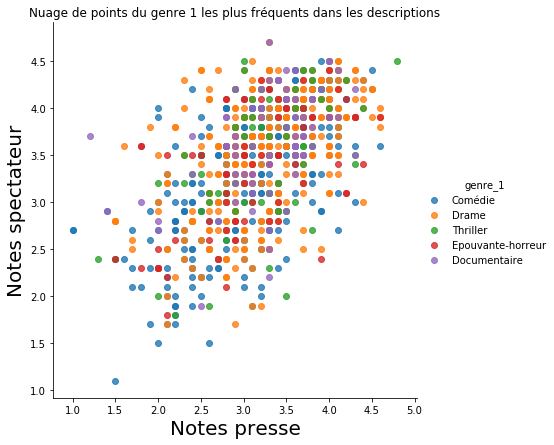

In [19]:
df_genre_1 = films.loc[films["genre_1"].isin(["Comédie","Drame", "Epouvante-horreur", "Thriller", "Documentaire",]), :]
# Tracer le graphique 
sns.lmplot(data=df_genre_1, x='note_presse', y='note_spectateur', fit_reg=False, hue='genre_1', size=6, aspect=1)
plt.xlabel('Notes presse', fontsize=20)
plt.ylabel('Notes spectateur', fontsize=20)
plt.title('Nuage de points du genre 1 les plus fréquents dans les descriptions', fontsize=12)

In [20]:
# Calculer le total pour chaque genre 
films['genre_2'].value_counts()

Drame                 219
Thriller              172
Romance               115
Action                112
Comédie               103
Aventure               86
Science fiction        59
Biopic                 56
Policier               48
Fantastique            42
Famille                39
Epouvante-horreur      35
Guerre                 29
Espionnage             23
Historique             19
Musical                12
Comédie musicale        7
Comédie dramatique      7
Documentaire            4
Judiciaire              4
Erotique                3
Western                 3
Sport event             3
Animation               3
Arts Martiaux           1
Name: genre_2, dtype: int64

Garder les genres 2 qui reviennent plus de 100 fois

C:\Users\lahat\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Nuage de points du genre 2 les plus fréquents dans les descriptions')

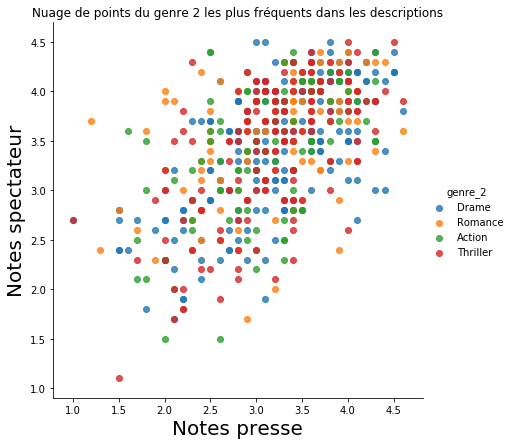

In [21]:
df_genre_2 = films.loc[films["genre_2"].isin(["Drame", "Thriller", "Romance","Action",]), :]
# Tracer le graphique 
sns.lmplot(data=df_genre_2, x='note_presse', y='note_spectateur', fit_reg=False, hue='genre_2', size=6, aspect=1)
plt.xlabel('Notes presse', fontsize=20)
plt.ylabel('Notes spectateur', fontsize=20)
plt.title('Nuage de points du genre 2 les plus fréquents dans les descriptions', fontsize=12)

Garder les films qui ont une durée supérieure ou égale à 1H 50min

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20]), <a list of 20 Text xticklabel objects>)

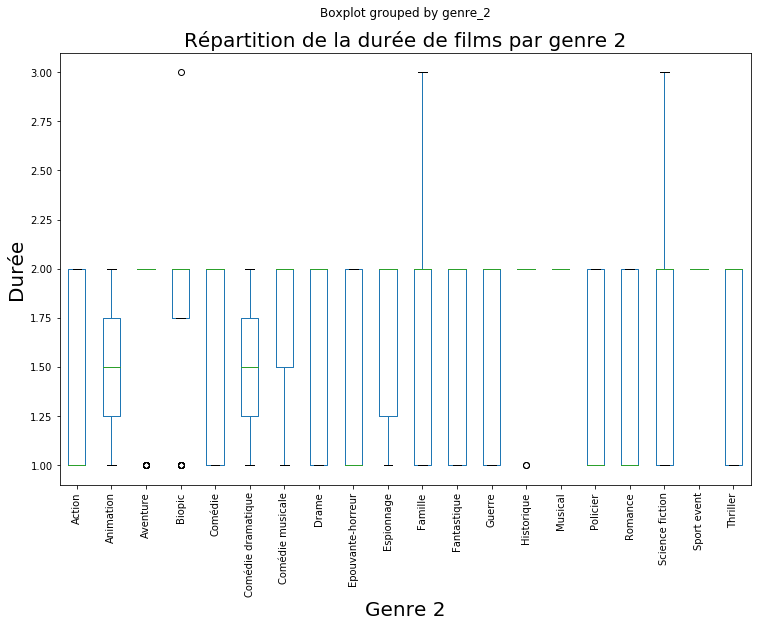

In [22]:
films_duree = films_duree[films_duree['duree'] > '1: 50']
# Convertir l'heure en entier
films_duree["heure"] = films_duree["heure"].astype('int')
# Tracer le boxplot du genre 2 en fonction de la durée
films_duree.boxplot(by="genre_2", column = ["heure"], grid=False, figsize=(12, 8))
plt.xlabel('Genre 2', fontsize=20)
plt.ylabel('Durée', fontsize=20)
plt.title("Répartition de la durée de films par genre 2", fontsize=20)
plt.xticks(rotation=90)

# TEXT MINING

In [23]:
# Définir un dataframe à utiliser pour le text mining
col_to_keep = ["titre", "description", "note_presse", "note_spectateur","genre_1","genre_2","genre_3"]
films_desc = films[col_to_keep]
films_desc.head()

,titre,description,note_presse,note_spectateur,genre_1,genre_2,genre_3
0,La Reine des neiges 2,Pourquoi Elsa est-elle née avec des pouvoirs m...,3.3,3.9,Animation,Drame,Drame
1,La Famille Addams,La famille Addams; qui vivait jusque-là retran...,2.9,2.8,Animation,Famille,Drame
3,J'accuse,Pendant les 12 années qu’elle dura; l’Affaire ...,4.0,3.8,Animation,Aventure,Thriller
4,Une vie cachée,Inspiré de faits réels.Franz Jägerstätter; pay...,4.0,3.8,Animation,Biopic,Thriller
5,Le Mans 66,Basé sur une histoire vraie; le film suit une ...,3.8,4.4,Animation,Drame,Thriller


Fonction pour le nettoyage de la description

In [24]:
def netoyage(desc):
    # supprimer la barre oblique inverse apostrophe
    desc = re.sub("\'", "", desc)
    # supprimer tous les caractères spéciaux
    desc = re.sub("[^ \w+0-9]", ' ', desc)
    # supprimer les espaces
    desc = ' '.join(desc.split())
    # Normaliser les chaines de caractères
    desc = unicodedata.normalize("NFKD", desc).encode("UTF-8", "ignore")
    # convertir le texte en minuscule
    desc = desc.lower()
    return desc

films_desc['desription_nettoyer'] = films_desc['description'].apply(lambda x: netoyage(x))
# Supprimer les accents
films_desc['desription_nettoyer'] = films_desc['desription_nettoyer'].str.decode('ascii', 'ignore')
# Suppresion des chiffres 
films_desc['desription_nettoyer'] = films_desc['desription_nettoyer'].str.replace('\d+', '')
# Compter le nombre de mots dans chaque description
films_desc['nombre_mots'] = films_desc['desription_nettoyer'].str.split().str.len()
films_desc.head()

C:\Users\lahat\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\lahat\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\lahat\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-d

,titre,description,note_presse,note_spectateur,genre_1,genre_2,genre_3,desription_nettoyer,nombre_mots
0,La Reine des neiges 2,Pourquoi Elsa est-elle née avec des pouvoirs m...,3.3,3.9,Animation,Drame,Drame,pourquoi elsa est elle nee avec des pouvoirs m...,70
1,La Famille Addams,La famille Addams; qui vivait jusque-là retran...,2.9,2.8,Animation,Famille,Drame,la famille addams qui vivait jusque la retranc...,247
3,J'accuse,Pendant les 12 années qu’elle dura; l’Affaire ...,4.0,3.8,Animation,Aventure,Thriller,pendant les annees qu elle dura l affaire dre...,108
4,Une vie cachée,Inspiré de faits réels.Franz Jägerstätter; pay...,4.0,3.8,Animation,Biopic,Thriller,inspire de faits reels franz jagerstatter pays...,61
5,Le Mans 66,Basé sur une histoire vraie; le film suit une ...,3.8,4.4,Animation,Drame,Thriller,base sur une histoire vraie le film suit une e...,52


Les Nuages de points sur le nombre de mots dans la description en fonction des notes

Text(0.5, 1.0, 'Biais entre le nombre de mots et la note de la presse')

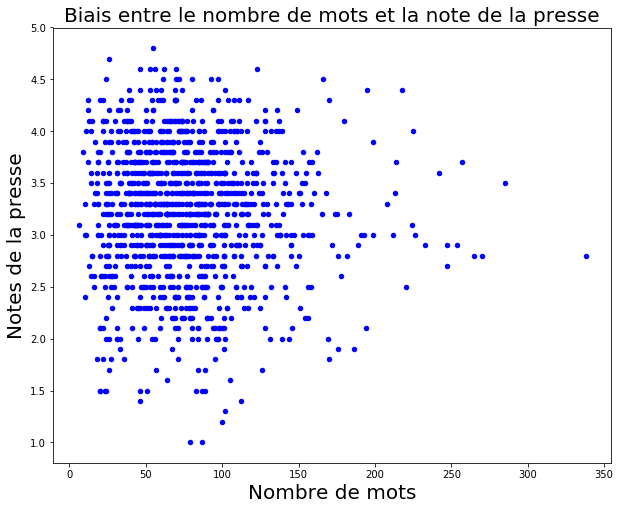

In [25]:
films_desc.plot.scatter(x='nombre_mots', y='note_presse', figsize=(10, 8), color='b')
plt.xlabel('Nombre de mots', fontsize=20)
plt.ylabel('Notes de la presse', fontsize=20)
plt.title('Biais entre le nombre de mots et la note de la presse', fontsize=20)

Text(0.5, 1.0, 'Biais entre le nombre de mots et la note de la presse')

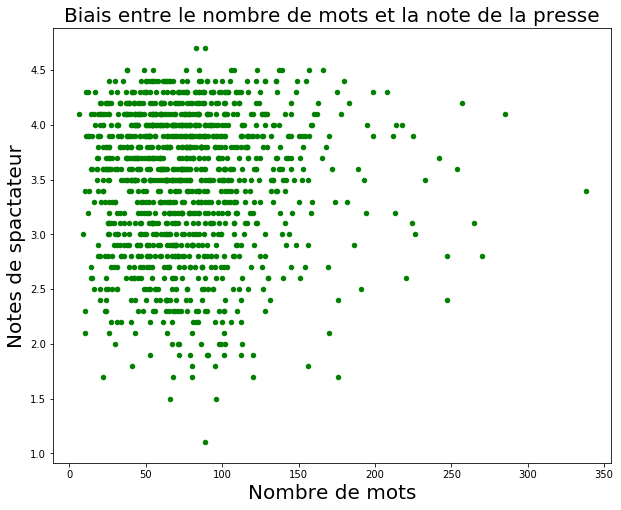

In [26]:
films_desc.plot.scatter(x='nombre_mots', y='note_spectateur', figsize=(10, 8), color='g')
plt.xlabel('Nombre de mots', fontsize=20)
plt.ylabel('Notes de spactateur', fontsize=20)
plt.title('Biais entre le nombre de mots et la note de la presse', fontsize=20)

In [27]:
films_desc.corr(method ='pearson')

,note_presse,note_spectateur,nombre_mots
note_presse,1.000000,0.552416,-0.037289
note_spectateur,0.552416,1.000000,0.014738
nombre_mots,-0.037289,0.014738,1.000000


Suppression des stopworlds

In [28]:
stop_words = stopwords.words('french')
def supp(desc):
    desc_sans_stopwords = [w for w in desc.split() if not w in stop_words]
    return ' '.join(desc_sans_stopwords)

films_desc['desc_sans_stopwords'] = films_desc['desription_nettoyer'].apply(lambda x: supp(x))

C:\Users\lahat\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Graphique des nuages de mots si genre 1 = Comédie et genre 2 = Drame

In [29]:
# Pour le genre 1 = Comédie
desc_drame = films_desc.loc[films["genre_1"].isin(["Comédie"]), :]
# Concaténer les descriptions
desc = desc_drame.desc_sans_stopwords.str.cat(sep=' ')
# les mettres dans une liste
tokens = word_tokenize(desc)
vocabulaire = set(tokens)
print("Longueur de vocabulaire de tous les mots utilisés dans les descriptions:", len(vocabulaire))

Longueur de vocabulaire de tous les mots utilisés dans les descriptions: 5987


In [30]:
freq_dist = nltk.FreqDist(tokens)
# les 50 mots les plus utilisés
frequence_mots = sorted(freq_dist,key=freq_dist.__getitem__, reverse=True)[0:50]
frequence_mots = ", ".join(word for word in frequence_mots)
print("\n50 mots les plus couramment utilisés sur les descriptions pendant la campagne:\n"+frequence_mots)


50 mots les plus couramment utilisés sur les descriptions pendant la campagne:
a, plus, vie, tout, va, deux, ans, famille, alors, leurs, jeune, monde, faire, pere, vont, etre, sans, apres, entre, femme, comme, bien, fait, seul, cette, sous, jamais, tous, tres, mere, fille, petit, aussi, quand, decide, nouvelle, dont, histoire, enfants, grand, retrouve, depuis, jour, vite, chez, temps, peu, trois, doit, amis


Text(0.5, 1.0, 'Nuage de mots des 50 mots les plus utilisés pour Genre 1 = Comédie')

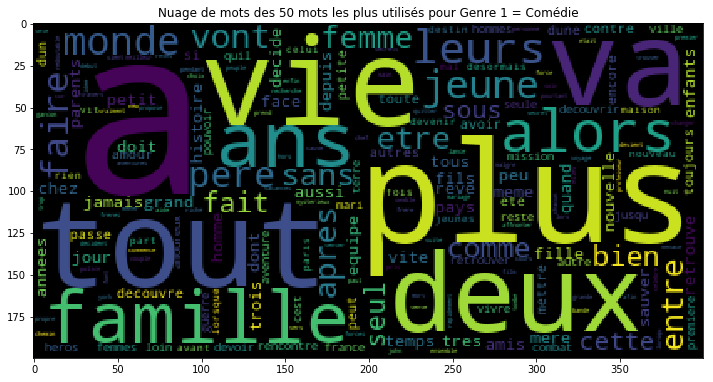

In [31]:
wordcloud = WordCloud().generate_from_frequencies(freq_dist)
# Tracer le graphique
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111)
ax.imshow(wordcloud)
ax.set_title('Nuage de mots des 50 mots les plus utilisés pour Genre 1 = Comédie')

In [32]:
# Pour le genre 2 = Drame
desc_drame_genre_2 = films_desc.loc[films["genre_2"].isin(["Drame"]), :]
# Concaténer les descriptions
desc_genre_2 = desc_drame_genre_2.desc_sans_stopwords.str.cat(sep=' ')
# les mettres dans une liste
tokens_genre_2 = word_tokenize(desc_genre_2)
vocabulaire_genre_2 = set(tokens_genre_2)
print("Longueur de vocabulaire de tous les mots utilisés dans les descriptions:", len(vocabulaire_genre_2))

Longueur de vocabulaire de tous les mots utilisés dans les descriptions: 4355


In [33]:
freq_dist_genre_2 = nltk.FreqDist(tokens_genre_2)
# les 50 mots les plus utilisés
frequence_mots_genre_2 = sorted(freq_dist_genre_2,key=freq_dist.__getitem__, reverse=True)[0:50]
frequence_mots_genre_2 = ", ".join(word for word in frequence_mots_genre_2)
print("\n50 mots les plus couramment utilisés sur les descriptions pendant la campagne:\n"+frequence_mots_genre_2)


50 mots les plus couramment utilisés sur les descriptions pendant la campagne:
a, plus, vie, tout, va, deux, ans, famille, alors, leurs, jeune, monde, faire, pere, vont, etre, sans, apres, femme, entre, comme, bien, fait, seul, cette, sous, jamais, tous, fille, mere, tres, petit, aussi, quand, decide, histoire, nouvelle, dont, grand, enfants, retrouve, depuis, jour, equipe, doit, vite, chez, temps, amis, peu


In [34]:
freq_dist_genre_2 = nltk.FreqDist(tokens_genre_2)
# les 50 mots les plus utilisés
frequence_mots_genre_2 = sorted(freq_dist_genre_2,key=freq_dist.__getitem__, reverse=True)[0:50]
frequence_mots_genre_2 = ", ".join(word for word in frequence_mots_genre_2)
print("\n50 mots les plus couramment utilisés sur les descriptions pendant la campagne:\n"+frequence_mots_genre_2)


50 mots les plus couramment utilisés sur les descriptions pendant la campagne:
a, plus, vie, tout, va, deux, ans, famille, alors, leurs, jeune, monde, faire, pere, vont, etre, sans, apres, femme, entre, comme, bien, fait, seul, cette, sous, jamais, tous, fille, mere, tres, petit, aussi, quand, decide, histoire, nouvelle, dont, grand, enfants, retrouve, depuis, jour, equipe, doit, vite, chez, temps, amis, peu


Text(0.5, 1.0, 'Nuage de mots des 50 mots les plus utilisés pour Genre 2 = Drame')

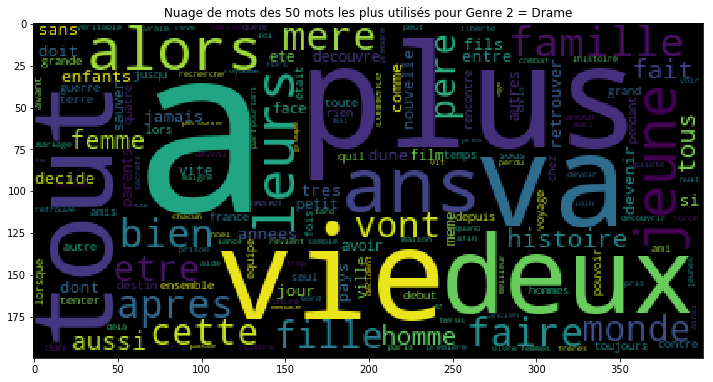

In [35]:
wordcloud_genre_2 = WordCloud().generate_from_frequencies(freq_dist_genre_2)
# Tracer le graphique
fig_2 = plt.figure(figsize = (12,8))
ax_2 = fig_2.add_subplot(111)
ax_2.imshow(wordcloud_genre_2)
ax_2.set_title('Nuage de mots des 50 mots les plus utilisés pour Genre 2 = Drame')

Prédiction du genre de film en fonction de la description

In [40]:
# Définir un dataframe films_predict
col_to_keep = ["titre","desc_sans_stopwords", "genre_2","genre_3"]
films_predict = films_desc[col_to_keep]
# Caalculer le nombre de mots
films_predict['nombre_mots'] = films_predict['desc_sans_stopwords'].str.split().str.len()
# La somme des mots dans notre dataframe
sum(films_predict['nombre_mots'])

C:\Users\lahat\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


56286

In [45]:
# Créer une matrice de fonctionnalités TF-IDF : Vectoriser 57362 mots de notre dataframe
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), max_features=57362)
# tranformer en tableau array
features = tfidf.fit_transform(films_predict.desc_sans_stopwords).toarray()
# Récupérer les labels du genre 2
labels = films_predict.genre_2
features.shape

(1204, 2282)

In [47]:
# Créer notre jeu de données entraiment jeu de données test
X_train, X_test, y_train, y_test = train_test_split(films_predict['desc_sans_stopwords'], films_predict['genre_2'], random_state = 0)
count_vect = CountVectorizer()
# Vectoriser le jeu de données entraiment
X_train_counts = count_vect.fit_transform(X_train)
X_test_counts = count_vect.fit_transform(X_test)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.fit_transform(X_test_counts)

Utiliser la régression logistique

In [48]:
lr = LogisticRegression()
# ajuster le classificateur par classe 
clf = OneVsRestClassifier(lr)
# ajustement du modèle sur les données du test
clf.fit(X_test_tfidf, y_test)
y_score_R_L = clf.score(X_test_tfidf, y_test)
y_score_R_L

C:\Users\lahat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6611295681063123

In [50]:
# Créer la variable genre prédit
films_predict["genre_2_prédit_rl"] = clf.predict(count_vect.transform(films_predict["desc_sans_stopwords"]))

C:\Users\lahat\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Utiliser de Naive Bayes

In [51]:
lr = MultinomialNB()
# ajuster le classificateur par classe 
clf = OneVsRestClassifier(lr)
# ajustement du modèle sur les données du test
clf.fit(X_test_tfidf, y_test)
y_score_N_B = clf.score(X_test_tfidf, y_test)
y_score_N_B

0.7242524916943521

In [52]:
# Créer la variable genre prédit
films_predict["genre_2_prédit_nb"] = clf.predict(count_vect.transform(films_predict["desc_sans_stopwords"]))
films_predict.head()

C:\Users\lahat\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,titre,desc_sans_stopwords,genre_2,genre_3,nombre_mots,genre_2_prédit_rl,genre_2_prédit_nb
0,La Reine des neiges 2,pourquoi elsa nee pouvoirs magiques jeune fill...,Drame,Drame,37,Thriller,Thriller
1,La Famille Addams,famille addams vivait jusque retranchee demeur...,Famille,Drame,138,Famille,Famille
3,J'accuse,pendant annees dura affaire dreyfus dechira fr...,Aventure,Thriller,64,Drame,Drame
4,Une vie cachée,inspire faits reels franz jagerstatter paysan ...,Biopic,Thriller,36,Drame,Drame
5,Le Mans 66,base histoire vraie film suit equipe dexcentri...,Drame,Thriller,33,Drame,Drame
